In [22]:
#Imports and libraries

import pandas as pd
import numpy as np
from numpy import linalg
import random as rand
import csv
import matplotlib.pyplot as plt
import scipy.stats as stats
from scipy.stats import norm
from sklearn import preprocessing
import collections
import math
import statistics

import sys  
sys.path.insert(0, '../scripts')
import krippendorff_alpha
import bootstrap_workers

sys.path.insert(0, '../scripts/xrr')
from xrr.xrr_class import xRR

import warnings
warnings.filterwarnings('ignore')

# Process experiment files and compute stats

In [8]:
#Read the data of the experiment

# To replicate the analysis, replace the LINK_TO_SOURCE_FILE with the source file

link = '../data/LINK_TO_SOURCE_FILE'
experiment = pd.read_csv(link)

repetition1 = experiment[(experiment["Experiment"] == "E1") & (experiment["Dataset"] == "Dataset 1") & (experiment["Week"] == 1)]
repetition2 = experiment[(experiment["Experiment"] == "E1") & (experiment["Dataset"] == "Dataset 1") & (experiment["Week"] == 2)]
repetition3 = experiment[(experiment["Experiment"] == "E1") & (experiment["Dataset"] == "Dataset 1") & (experiment["Week"] == 3)]
repetition4 = experiment[(experiment["Experiment"] == "E1") & (experiment["Dataset"] == "Dataset 1") & (experiment["Week"] == 4)]
repetition5 = experiment[(experiment["Experiment"] == "E1") & (experiment["Dataset"] == "Dataset 1") & (experiment["Week"] == 5)]

In [9]:
#Get rater ids and the total number of raters per repetition

raterIds1 = list(set(list(repetition1["WorkerId"])))
raterIds2 = list(set(list(repetition2["WorkerId"])))
raterIds3 = list(set(list(repetition3["WorkerId"])))
raterIds4 = list(set(list(repetition4["WorkerId"])))
raterIds5 = list(set(list(repetition5["WorkerId"])))

print("Number of raters in Repetition 1: ", len(raterIds1))
print("Number of raters in Repetition 2: ", len(raterIds2))
print("Number of raters in Repetition 3: ", len(raterIds3))
print("Number of raters in Repetition 4: ", len(raterIds4))
print("Number of raters in Repetition 5: ", len(raterIds5))

Number of raters in Repetition 1:  123
Number of raters in Repetition 2:  124
Number of raters in Repetition 3:  124
Number of raters in Repetition 4:  128
Number of raters in Repetition 5:  124


In [13]:
#Process the results of all repetitions and compute stats

import statistics as sts

classes = {"infrastructure_and_utilities_damage" : 1,
           "injured_or_dead_people" : 2,
           "caution_and_advice" : 3,
           "donation_needs_or_offers_or_volunteering_services" : 4,
           "other_useful_information" : 5,
           "sympathy_and_emotional_support" : 6,
           "displaced_people_and_evacuations" : 7,
           "not_related_or_irrelevant" : 8,
           "Missing_trapped_or_found+people" : 9}

def process_judgments(repetition, repetitions, rep_index):
    for i in range(len(repetition)):
        docs = repetition["Answer.serialized_field"].iloc[i].split("&")
        index = 1
        for doc in docs:
            annotation = []
            annotation.append(index)
            annotation.append(rep_index)
            annotation.append(repetition["WorkerId"].iloc[i])
            annotation.append(classes[doc.split("=")[1]])

            for cl in classes:
                if doc.split("=")[1] == cl:
                    annotation.append(1)
                else: 
                    annotation.append(0)

            repetitions.append(annotation)
            index += 1
    return repetitions
 
repetitions = []
repetitions = process_judgments(repetition1, repetitions, "Repetition 1")
repetitions = process_judgments(repetition2, repetitions, "Repetition 2")
repetitions = process_judgments(repetition3, repetitions, "Repetition 3")
repetitions = process_judgments(repetition4, repetitions, "Repetition 4")
repetitions = process_judgments(repetition5, repetitions, "Repetition 5")

columns = ["ItemId", "Repetition", "Rater", "Classification", "infrastructure_and_utilities_damage", 
           "injured_or_dead_people", "caution_and_advice", 
           "donation_needs_or_offers_or_volunteering_services", "other_useful_information",
           "sympathy_and_emotional_support", "displaced_people_and_evacuations",
           "not_related_or_irrelevant", "Missing_trapped_or_found+people"]
datadf = pd.DataFrame(repetitions, columns = columns)
datadf.to_csv("../data/CT_cleaned_dataset.csv", index=False)

In [15]:
datadf.head(5)

,ItemId,Repetition,Rater,Classification,infrastructure_and_utilities_damage,injured_or_dead_people,caution_and_advice,donation_needs_or_offers_or_volunteering_services,other_useful_information,sympathy_and_emotional_support,displaced_people_and_evacuations,not_related_or_irrelevant,Missing_trapped_or_found+people
0,1,Repetition 1,1454,1,1,0,0,0,0,0,0,0,0
1,2,Repetition 1,1454,5,0,0,0,0,1,0,0,0,0
2,3,Repetition 1,1454,5,0,0,0,0,1,0,0,0,0
3,4,Repetition 1,1454,6,0,0,0,0,0,1,0,0,0
4,5,Repetition 1,1454,5,0,0,0,0,1,0,0,0,0


# Agreement Analysis

In [29]:
# Compute the IRR score of the experiment
repetition1 = datadf[datadf["Repetition"] == "Repetition 1"]
repetition2 = datadf[datadf["Repetition"] == "Repetition 2"]
repetition3 = datadf[datadf["Repetition"] == "Repetition 3"]
repetition4 = datadf[datadf["Repetition"] == "Repetition 4"]
repetition5 = datadf[datadf["Repetition"] == "Repetition 5"]

def compute_dataset_agreement(repetition, answer_column, repetition_index):
    data = [list(repetition[answer_column])[i * 20:(i + 1) * 20] for i in range((len(list(repetition[answer_column])) + 20 - 1) // 20 )]
    missing = "*"
    kappa = krippendorff_alpha.krippendorff_alpha(data, metric=krippendorff_alpha.nominal_metric, missing_items=missing)
    print("Krippendorff's alpha for", repetition_index, ": ", round(kappa, 4))

compute_dataset_agreement(repetition1, "Classification", "Repetition 1")
compute_dataset_agreement(repetition2, "Classification", "Repetition 2")
compute_dataset_agreement(repetition3, "Classification", "Repetition 3")
compute_dataset_agreement(repetition4, "Classification", "Repetition 4")
compute_dataset_agreement(repetition5, "Classification", "Repetition 5")

Krippendorff's alpha for Repetition 1 :  0.5874
Krippendorff's alpha for Repetition 2 :  0.6957
Krippendorff's alpha for Repetition 3 :  0.6764
Krippendorff's alpha for Repetition 4 :  0.7237
Krippendorff's alpha for Repetition 5 :  0.6514


In [33]:
#Compute the IRR score for each possible answer and in each experiment

classifs = ["infrastructure_and_utilities_damage", 
           "injured_or_dead_people", "caution_and_advice", 
           "donation_needs_or_offers_or_volunteering_services", "other_useful_information",
           "sympathy_and_emotional_support", "displaced_people_and_evacuations",
           "not_related_or_irrelevant", "Missing_trapped_or_found+people"]

def compute_agrm_per_class(repetition):
    data = [list(repetition[cls])[i * 20:(i + 1) * 20] for i in range((len(list(repetition[cls])) + 20 - 1) // 20 )]
    missing = "*"
    alpha = krippendorff_alpha.krippendorff_alpha(data, metric=krippendorff_alpha.nominal_metric, missing_items=missing)
    return alpha

for cls in classifs:
    print(cls)
    
    alpha = compute_agrm_per_class(repetition1)
    print("Krippendorff's alpha for Repetition 1:", round(alpha, 4))

    alpha = compute_agrm_per_class(repetition2)
    print("Krippendorff's alpha for Repetition 2:", round(alpha, 4))

    alpha = compute_agrm_per_class(repetition3)
    print("Krippendorff's alpha for Repetition 3:", round(alpha, 4))

    alpha = compute_agrm_per_class(repetition4)
    print("Krippendorff's alpha for Repetition 4:", round(alpha, 4))

    alpha = compute_agrm_per_class(repetition5)
    print("Krippendorff's alpha for Repetition 5:", round(alpha, 4))



infrastructure_and_utilities_damage
Krippendorff's alpha for Repetition 1: 0.4436
Krippendorff's alpha for Repetition 2: 0.5622
Krippendorff's alpha for Repetition 3: 0.5309
Krippendorff's alpha for Repetition 4: 0.566
Krippendorff's alpha for Repetition 5: 0.5174
injured_or_dead_people
Krippendorff's alpha for Repetition 1: 0.8227
Krippendorff's alpha for Repetition 2: 0.9332
Krippendorff's alpha for Repetition 3: 0.9036
Krippendorff's alpha for Repetition 4: 0.9506
Krippendorff's alpha for Repetition 5: 0.8767
caution_and_advice
Krippendorff's alpha for Repetition 1: 0.4242
Krippendorff's alpha for Repetition 2: 0.5632
Krippendorff's alpha for Repetition 3: 0.5615
Krippendorff's alpha for Repetition 4: 0.5085
Krippendorff's alpha for Repetition 5: 0.5164
donation_needs_or_offers_or_volunteering_services
Krippendorff's alpha for Repetition 1: 0.7844
Krippendorff's alpha for Repetition 2: 0.8276
Krippendorff's alpha for Repetition 3: 0.8412
Krippendorff's alpha for Repetition 4: 0.8743

# Precision Analysis

In [51]:
def iqv_metric(elems, total):
    pct = 0
    for elem in elems:
        pct += ((elem * 100)/total) ** 2

    iqv = (len(elems) * (10000 - pct)) / (10000 * (len(elems) - 1))
    return iqv

def majority_answer(df, column_name, pos_val):
    counts = []
    for elem in pos_val:
        counts.append(list(df[column_name]).count(elem))
    return counts

def compute_stats_per_item(item_id, repetition, item_column, pos_val, column_name):
    subset = repetition[repetition[item_column] == unit]
    maj_ans = majority_answer(subset, column_name, pos_val)
    
    return maj_ans.index(max(maj_ans)) + 1
    

units = list(set(datadf["ItemId"]))
pos_val = [1,2,3,4,5,6,7,8,9]
columns = ["item_id", "Repetition 1", "Repetition 2", "Repetition 3", "Repetition 4", "Repetition 5", "IQV 1", "IQV 2", "IQV 3", "IQV 4", "IQV 5"]

rows = []
for unit in units:
    row = [unit]
    maj_answer1 = compute_stats_per_item(unit, repetition1, "ItemId", pos_val, "Classification")
    maj_answer2 = compute_stats_per_item(unit, repetition2, "ItemId", pos_val, "Classification")
    maj_answer3 = compute_stats_per_item(unit, repetition3, "ItemId", pos_val, "Classification")
    maj_answer4 = compute_stats_per_item(unit, repetition4, "ItemId", pos_val, "Classification")
    maj_answer5 = compute_stats_per_item(unit, repetition5, "ItemId", pos_val, "Classification")
    
    row.extend([maj_answer1, maj_answer2, maj_answer3, maj_answer4, maj_answer5])
    
    subset1 = repetition1[repetition1["ItemId"] == unit]
    subset2 = repetition2[repetition2["ItemId"] == unit]
    subset3 = repetition3[repetition3["ItemId"] == unit]
    subset4 = repetition4[repetition4["ItemId"] == unit]
    subset5 = repetition5[repetition5["ItemId"] == unit]
    
    iqv1 = iqv_metric(majority_answer(subset1, "Classification", pos_val), len(subset1))
    iqv2 = iqv_metric(majority_answer(subset2, "Classification", pos_val), len(subset2))
    iqv3 = iqv_metric(majority_answer(subset3, "Classification", pos_val), len(subset3))
    iqv4 = iqv_metric(majority_answer(subset4, "Classification", pos_val), len(subset4))
    iqv5 = iqv_metric(majority_answer(subset5, "Classification", pos_val), len(subset5))

    row.extend([round(iqv1, 4), round(iqv2, 4), round(iqv3, 4), round(iqv4, 4), round(iqv5, 4)])
    rows.append(row) 

precision_df = pd.DataFrame(rows, columns = columns)

In [52]:
precision_df

,item_id,Repetition 1,Repetition 2,Repetition 3,Repetition 4,Repetition 5,IQV 1,IQV 2,IQV 3,IQV 4,IQV 5
0,1,1,1,1,1,1,0.7855,0.7573,0.7454,0.7118,0.7122
1,2,8,1,8,8,8,0.8767,0.8522,0.8385,0.8179,0.7902
2,3,1,1,1,1,1,0.4658,0.2515,0.3357,0.2847,0.3112
3,4,6,6,6,6,6,0.1904,0.1393,0.1886,0.0856,0.2208
4,5,5,5,3,5,5,0.6789,0.6351,0.6212,0.5926,0.6667
5,6,5,5,5,5,5,0.7925,0.7786,0.7281,0.7049,0.7039
6,7,2,2,2,2,2,0.2057,0.1727,0.1393,0.0689,0.1395
7,8,7,7,7,7,7,0.6554,0.3815,0.3532,0.3435,0.5246
8,9,2,2,2,2,2,0.1405,0.0534,0.0884,0.0347,0.0882
9,10,1,1,1,1,1,0.3935,0.3096,0.2763,0.2558,0.3791


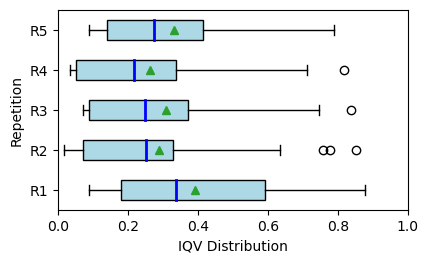

In [53]:
import matplotlib.pyplot as plt
import numpy as np
 
# Creating dataset
np.random.seed(10)

data = [precision_df["IQV 1"], precision_df["IQV 2"], precision_df["IQV 3"], precision_df["IQV 4"], precision_df["IQV 5"]]
 
fig = plt.figure(figsize =(3.5, 2))
plt.rcParams['axes.grid'] = False
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
 
# Creating plot
bp = ax.boxplot(data, patch_artist = True, vert = 0, showmeans=True)

for patch in bp['boxes']:
    patch.set_facecolor("lightblue")

for mean in bp['means']:
    mean.set_color("blue") 

for median in bp['medians']:
    median.set(color ='blue', linewidth = 2)

ax.set_yticklabels(['R1', 'R2', 'R3', 'R4', 'R5'])
ax.set_xlim(0, 1)
ax.set_xlabel("IQV Distribution")
ax.set_ylabel("Repetition")
# show plot
fig.show()
fig.savefig("../plots/ct_iqv.png", bbox_inches='tight', format="png", dpi=1200)

# Stability Analysis

In [56]:
from scipy import stats
from itertools import combinations

repetitions = ["Repetition 1", "Repetition 2", "Repetition 3", "Repetition 4", "Repetition 5"]
combs = list(combinations(repetitions, 2))
for comb in combs:
    crosstab = pd.crosstab(precision_df[comb[0]], precision_df[comb[1]])
    print(comb[0], " vs. ", comb[1], ":", stats.chi2_contingency(crosstab))

Repetition 1  vs.  Repetition 2 : (127.5, 6.494743419171254e-09, 49, array([[0.6 , 0.75, 0.15, 0.45, 0.3 , 0.3 , 0.3 , 0.15],
       [1.  , 1.25, 0.25, 0.75, 0.5 , 0.5 , 0.5 , 0.25],
       [0.2 , 0.25, 0.05, 0.15, 0.1 , 0.1 , 0.1 , 0.05],
       [0.6 , 0.75, 0.15, 0.45, 0.3 , 0.3 , 0.3 , 0.15],
       [0.4 , 0.5 , 0.1 , 0.3 , 0.2 , 0.2 , 0.2 , 0.1 ],
       [0.4 , 0.5 , 0.1 , 0.3 , 0.2 , 0.2 , 0.2 , 0.1 ],
       [0.4 , 0.5 , 0.1 , 0.3 , 0.2 , 0.2 , 0.2 , 0.1 ],
       [0.4 , 0.5 , 0.1 , 0.3 , 0.2 , 0.2 , 0.2 , 0.1 ]]))
Repetition 1  vs.  Repetition 3 : (125.0, 1.4390239586651936e-08, 49, array([[0.45, 0.75, 0.3 , 0.45, 0.15, 0.3 , 0.3 , 0.3 ],
       [0.75, 1.25, 0.5 , 0.75, 0.25, 0.5 , 0.5 , 0.5 ],
       [0.15, 0.25, 0.1 , 0.15, 0.05, 0.1 , 0.1 , 0.1 ],
       [0.45, 0.75, 0.3 , 0.45, 0.15, 0.3 , 0.3 , 0.3 ],
       [0.3 , 0.5 , 0.2 , 0.3 , 0.1 , 0.2 , 0.2 , 0.2 ],
       [0.3 , 0.5 , 0.2 , 0.3 , 0.1 , 0.2 , 0.2 , 0.2 ],
       [0.3 , 0.5 , 0.2 , 0.3 , 0.1 , 0.2 , 0.2 , 0.2 ],
    

# Replicability Analysis

In [73]:
repetition1.name = "Repetition 1"
repetition2.name = "Repetition 2"
repetition3.name = "Repetition 3"
repetition4.name = "Repetition 4"
repetition5.name = "Repetition 5"

combs = combinations([repetition1, repetition2, repetition3, repetition4, repetition5], 2)

xRR_matrix = np.ones((5, 5), dtype = float)

for comb in list(combs):
    xRR_object = xRR(comb[0], comb[1], "Classification", "Rater", "ItemId")
    print("xRR score between " + comb[0].name + " and " + comb[1].name + " is:", xRR_object.kappa_x())
    xRR_matrix[int(comb[1].name[-1]) - 1, int(comb[0].name[-1]) - 1] = xRR_object.kappa_x()
                
print(xRR_matrix)

21/08/2023 17:27:35  observed disagreement: 0.30884801993183364
21/08/2023 17:27:36  expected disagreement: 0.8527048911618148


xRR score between Repetition 1 and Repetition 2 is: 0.6378019838598245


21/08/2023 17:27:36  observed disagreement: 0.3163814581694397
21/08/2023 17:27:36  expected disagreement: 0.8535629753474954


xRR score between Repetition 1 and Repetition 3 is: 0.6293402276022608


21/08/2023 17:27:36  observed disagreement: 0.2973323170731885
21/08/2023 17:27:37  expected disagreement: 0.8525150851117886


xRR score between Repetition 1 and Repetition 4 is: 0.6512292600262904


21/08/2023 17:27:37  observed disagreement: 0.3273373983740028
21/08/2023 17:27:37  expected disagreement: 0.854829858379229


xRR score between Repetition 1 and Repetition 5 is: 0.6170730407163834


21/08/2023 17:27:37  observed disagreement: 0.2678037200832673
21/08/2023 17:27:38  expected disagreement: 0.8524091116024974


xRR score between Repetition 2 and Repetition 3 is: 0.6858272437048376


21/08/2023 17:27:38  observed disagreement: 0.24761844758065343
21/08/2023 17:27:38  expected disagreement: 0.8513777406754032


xRR score between Repetition 2 and Repetition 4 is: 0.7091556006805908


21/08/2023 17:27:39  observed disagreement: 0.2806191467221847
21/08/2023 17:27:39  expected disagreement: 0.8537475611342352


xRR score between Repetition 2 and Repetition 5 is: 0.6713089916773856


21/08/2023 17:27:39  observed disagreement: 0.25563256048388194
21/08/2023 17:27:39  expected disagreement: 0.8522572769657258


xRR score between Repetition 3 and Repetition 4 is: 0.7000523581400147


21/08/2023 17:27:40  observed disagreement: 0.2879682622268643
21/08/2023 17:27:40  expected disagreement: 0.8546648998439126


xRR score between Repetition 3 and Repetition 5 is: 0.6630629592025414


21/08/2023 17:27:40  observed disagreement: 0.2672032510080778
21/08/2023 17:27:40  expected disagreement: 0.8534367124495967


xRR score between Repetition 4 and Repetition 5 is: 0.6869091203715254
[[1.         1.         1.         1.         1.        ]
 [0.63780198 1.         1.         1.         1.        ]
 [0.62934023 0.68582724 1.         1.         1.        ]
 [0.65122926 0.7091556  0.70005236 1.         1.        ]
 [0.61707304 0.67130899 0.66306296 0.68690912 1.        ]]


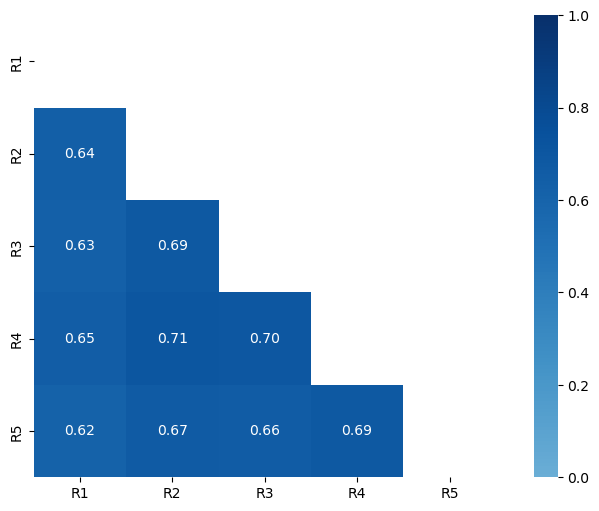

In [75]:
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt

columns = ["R1", "R2", "R3", "R4", "R5"]

df_data = pd.DataFrame(xRR_matrix, columns = columns)

# Create a mask
mask = np.triu(np.ones_like(df_data, dtype=bool))

plt.figure(figsize=(10, 6))
sns.heatmap(df_data, mask=mask, center=0, annot=True,
            fmt='.2f', square=True, cmap="Blues", yticklabels=["R1", "R2", "R3", "R4", "R5"], 
            vmin=0.0, vmax=1.0)

plt.savefig("../plots/xRR_CT.png",  bbox_inches='tight', format='png', dpi=1200)
plt.show()



infrastructure_and_utilities_damage


21/08/2023 17:40:11  observed disagreement: 0.1295338316286355
21/08/2023 17:40:11  expected disagreement: 0.2572646210333071
21/08/2023 17:40:11  observed disagreement: 0.13298583792289212
21/08/2023 17:40:12  expected disagreement: 0.25810647783897195
21/08/2023 17:40:12  observed disagreement: 0.1278931656504178
21/08/2023 17:40:12  expected disagreement: 0.25615091463414635
21/08/2023 17:40:12  observed disagreement: 0.13142538683451027
21/08/2023 17:40:13  expected disagreement: 0.25024914765276685
21/08/2023 17:40:13  observed disagreement: 0.11693548387096511
21/08/2023 17:40:13  expected disagreement: 0.2575344693028096
21/08/2023 17:40:13  observed disagreement: 0.11159274193549534
21/08/2023 17:40:14  expected disagreement: 0.25557428175403224
21/08/2023 17:40:14  observed disagreement: 0.11623309053069462
21/08/2023 17:40:14  expected disagreement: 0.24965855879292403
21/08/2023 17:40:14  observed disagreement: 0.11512096774194594
21/08/2023 17:40:15  expected disagreement: 

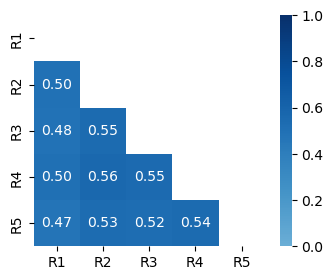

injured_or_dead_people


21/08/2023 17:40:16  observed disagreement: 0.046243115656962416
21/08/2023 17:40:16  expected disagreement: 0.37296551271964334
21/08/2023 17:40:17  observed disagreement: 0.051127720954628156
21/08/2023 17:40:17  expected disagreement: 0.37174009965906113
21/08/2023 17:40:17  observed disagreement: 0.04307037601625964
21/08/2023 17:40:18  expected disagreement: 0.3729782774390244
21/08/2023 17:40:18  observed disagreement: 0.055759900340938
21/08/2023 17:40:18  expected disagreement: 0.37112739312877
21/08/2023 17:40:18  observed disagreement: 0.030404526534859304
21/08/2023 17:40:19  expected disagreement: 0.3729786680541103
21/08/2023 17:40:19  observed disagreement: 0.021805695564516017
21/08/2023 17:40:19  expected disagreement: 0.3742048891129032
21/08/2023 17:40:19  observed disagreement: 0.0355944328824139
21/08/2023 17:40:20  expected disagreement: 0.372371878251821
21/08/2023 17:40:20  observed disagreement: 0.02720514112903205
21/08/2023 17:40:20  expected disagreement: 0.3

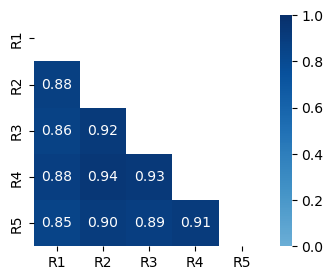

caution_and_advice


21/08/2023 17:40:22  observed disagreement: 0.07388539207972555
21/08/2023 17:40:22  expected disagreement: 0.14476789929189615
21/08/2023 17:40:22  observed disagreement: 0.07672108575924297
21/08/2023 17:40:22  expected disagreement: 0.15051927616050353
21/08/2023 17:40:23  observed disagreement: 0.07845210873984317
21/08/2023 17:40:23  expected disagreement: 0.14701981707317074
21/08/2023 17:40:23  observed disagreement: 0.07657684238132538
21/08/2023 17:40:23  expected disagreement: 0.14442958300550748
21/08/2023 17:40:24  observed disagreement: 0.06444458896982186
21/08/2023 17:40:24  expected disagreement: 0.1472912330905307
21/08/2023 17:40:24  observed disagreement: 0.06653855846774662
21/08/2023 17:40:25  expected disagreement: 0.14375945060483872
21/08/2023 17:40:25  observed disagreement: 0.06482180020811536
21/08/2023 17:40:25  expected disagreement: 0.14114529136316337
21/08/2023 17:40:25  observed disagreement: 0.06961315524194049
21/08/2023 17:40:26  expected disagreemen

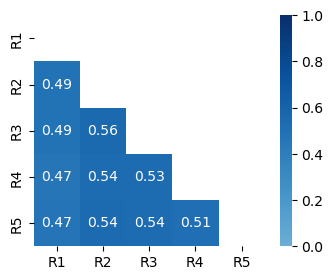

donation_needs_or_offers_or_volunteering_services


21/08/2023 17:40:27  observed disagreement: 0.04982625229478021
21/08/2023 17:40:27  expected disagreement: 0.25725806451612904
21/08/2023 17:40:28  observed disagreement: 0.047597036454234735
21/08/2023 17:40:28  expected disagreement: 0.2544387621295568
21/08/2023 17:40:28  observed disagreement: 0.04406758130081244
21/08/2023 17:40:28  expected disagreement: 0.25692327235772355
21/08/2023 17:40:29  observed disagreement: 0.05140637293469618
21/08/2023 17:40:29  expected disagreement: 0.252183320220299
21/08/2023 17:40:29  observed disagreement: 0.04220863683662798
21/08/2023 17:40:30  expected disagreement: 0.25613586108220604
21/08/2023 17:40:30  observed disagreement: 0.038451360887096435
21/08/2023 17:40:30  expected disagreement: 0.2586032006048387
21/08/2023 17:40:30  observed disagreement: 0.04640348595213258
21/08/2023 17:40:31  expected disagreement: 0.2538960067637877
21/08/2023 17:40:31  observed disagreement: 0.03627142137096743
21/08/2023 17:40:31  expected disagreement:

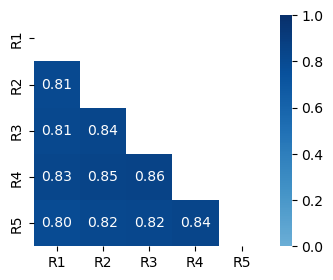

other_useful_information


21/08/2023 17:40:33  observed disagreement: 0.1328219249934402
21/08/2023 17:40:33  expected disagreement: 0.17449449252557042
21/08/2023 17:40:33  observed disagreement: 0.1369623655913944
21/08/2023 17:40:33  expected disagreement: 0.17805369787568842
21/08/2023 17:40:34  observed disagreement: 0.13612169715448577
21/08/2023 17:40:34  expected disagreement: 0.18278582317073172
21/08/2023 17:40:34  observed disagreement: 0.13777209546288674
21/08/2023 17:40:34  expected disagreement: 0.18420141620771047
21/08/2023 17:40:35  observed disagreement: 0.13128251821019488
21/08/2023 17:40:35  expected disagreement: 0.17450247138397504
21/08/2023 17:40:35  observed disagreement: 0.12994581653227408
21/08/2023 17:40:36  expected disagreement: 0.1792867943548387
21/08/2023 17:40:36  observed disagreement: 0.13136056191466947
21/08/2023 17:40:36  expected disagreement: 0.18071800208116545
21/08/2023 17:40:36  observed disagreement: 0.13417338709678905
21/08/2023 17:40:37  expected disagreement:

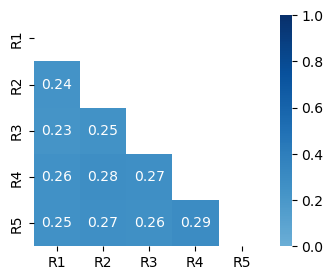

sympathy_and_emotional_support


21/08/2023 17:40:38  observed disagreement: 0.05052452137424534
21/08/2023 17:40:38  expected disagreement: 0.20135719905586152
21/08/2023 17:40:38  observed disagreement: 0.0487772095462884
21/08/2023 17:40:39  expected disagreement: 0.19732985837922895
21/08/2023 17:40:39  observed disagreement: 0.04458523882113769
21/08/2023 17:40:39  expected disagreement: 0.19898532774390243
21/08/2023 17:40:39  observed disagreement: 0.05540257015473301
21/08/2023 17:40:40  expected disagreement: 0.19887883556254918
21/08/2023 17:40:40  observed disagreement: 0.03830645161290291
21/08/2023 17:40:40  expected disagreement: 0.1937343912591051
21/08/2023 17:40:41  observed disagreement: 0.03401587701612879
21/08/2023 17:40:41  expected disagreement: 0.19540952620967741
21/08/2023 17:40:41  observed disagreement: 0.045369406867845595
21/08/2023 17:40:41  expected disagreement: 0.19530176899063476
21/08/2023 17:40:42  observed disagreement: 0.032220262096773984
21/08/2023 17:40:42  expected disagreeme

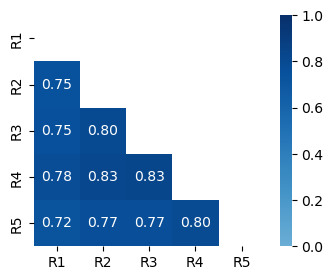

displaced_people_and_evacuations


21/08/2023 17:40:43  observed disagreement: 0.06291633884080652
21/08/2023 17:40:44  expected disagreement: 0.15633359559402046
21/08/2023 17:40:44  observed disagreement: 0.06350970364542234
21/08/2023 17:40:44  expected disagreement: 0.15667453448728036
21/08/2023 17:40:44  observed disagreement: 0.0560054623983797
21/08/2023 17:40:45  expected disagreement: 0.15154979674796748
21/08/2023 17:40:45  observed disagreement: 0.06317859952792952
21/08/2023 17:40:45  expected disagreement: 0.15087857330186205
21/08/2023 17:40:45  observed disagreement: 0.047561134235171006
21/08/2023 17:40:46  expected disagreement: 0.1699219562955255
21/08/2023 17:40:46  observed disagreement: 0.039591733870968336
21/08/2023 17:40:46  expected disagreement: 0.16499495967741937
21/08/2023 17:40:46  observed disagreement: 0.049362643080124134
21/08/2023 17:40:47  expected disagreement: 0.16434963579604578
21/08/2023 17:40:47  observed disagreement: 0.04008946572580684
21/08/2023 17:40:47  expected disagreem

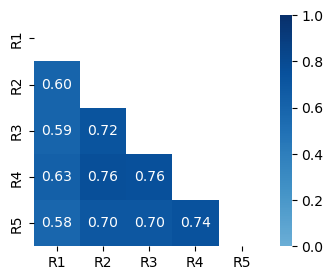

not_related_or_irrelevant


21/08/2023 17:40:49  observed disagreement: 0.05146865984788781
21/08/2023 17:40:49  expected disagreement: 0.12045239968528718
21/08/2023 17:40:49  observed disagreement: 0.05111460792027166
21/08/2023 17:40:49  expected disagreement: 0.11622738001573564
21/08/2023 17:40:50  observed disagreement: 0.047948424796752494
21/08/2023 17:40:50  expected disagreement: 0.12208079268292683
21/08/2023 17:40:50  observed disagreement: 0.060733018620507666
21/08/2023 17:40:50  expected disagreement: 0.13523996852871756
21/08/2023 17:40:51  observed disagreement: 0.04970733610821974
21/08/2023 17:40:51  expected disagreement: 0.11790452653485953
21/08/2023 17:40:51  observed disagreement: 0.046112651209681506
21/08/2023 17:40:52  expected disagreement: 0.12373235887096774
21/08/2023 17:40:52  observed disagreement: 0.05899453694068587
21/08/2023 17:40:52  expected disagreement: 0.13683402705515088
21/08/2023 17:40:52  observed disagreement: 0.04578503024194072
21/08/2023 17:40:53  expected disagre

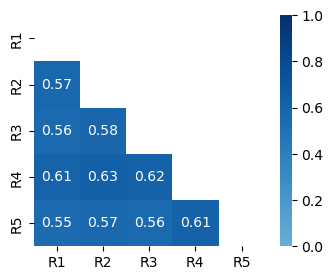

Missing_trapped_or_found+people


21/08/2023 17:40:54  observed disagreement: 0.02047600314712823
21/08/2023 17:40:54  expected disagreement: 0.020515997901914503
21/08/2023 17:40:55  observed disagreement: 0.0239673485444532
21/08/2023 17:40:55  expected disagreement: 0.02403586414896407
21/08/2023 17:40:55  observed disagreement: 0.016520579268292614
21/08/2023 17:40:55  expected disagreement: 0.01655614837398374
21/08/2023 17:40:56  observed disagreement: 0.02242001049042746
21/08/2023 17:40:56  expected disagreement: 0.022471479150275375
21/08/2023 17:40:56  observed disagreement: 0.014756763787721129
21/08/2023 17:40:56  expected disagreement: 0.014814646201873049
21/08/2023 17:40:57  observed disagreement: 0.0071824596774193415
21/08/2023 17:40:57  expected disagreement: 0.007190020161290322
21/08/2023 17:40:57  observed disagreement: 0.01309833506763785
21/08/2023 17:40:57  expected disagreement: 0.013219953173777315
21/08/2023 17:40:58  observed disagreement: 0.010786290322580659
21/08/2023 17:40:58  expected d

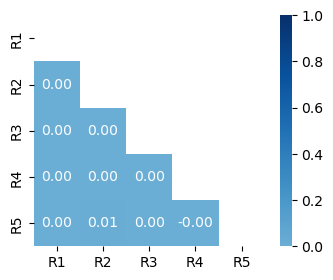

In [82]:
repetition1.name = "Repetition 1"
repetition2.name = "Repetition 2"
repetition3.name = "Repetition 3"
repetition4.name = "Repetition 4"
repetition5.name = "Repetition 5"

for cls in classifs:
    print(cls)
    combs = combinations([repetition1, repetition2, repetition3, repetition4, repetition5], 2)
    
    xRR_matrix = np.ones((5, 5), dtype = float)

    for comb in list(combs):
        xRR_object = xRR(comb[0], comb[1], cls, "Rater", "ItemId")
        #print("xRR score between " + comb[0].name + " and " + comb[1].name + " is:", xRR_object.kappa_x())
        xRR_matrix[int(comb[1].name[-1]) - 1, int(comb[0].name[-1]) - 1] = xRR_object.kappa_x()

    #print("xRR scores for the label ", cls, ": ", xRR_matrix)
    
    columns = ["R1", "R2", "R3", "R4", "R5"]

    df_data = pd.DataFrame(xRR_matrix, columns = columns)

    # Create a mask
    mask = np.triu(np.ones_like(df_data, dtype=bool))

    plt.figure(figsize=(4, 3))
    sns.heatmap(df_data, mask=mask, center=0, annot=True,
                fmt='.2f', square=True, cmap="Blues", yticklabels=["R1", "R2", "R3", "R4", "R5"], 
                vmin=0.0, vmax=1.0)

    plt.show()

# Power Analysis

In [83]:
#Functions used to generate sets of workers per item

def get_uniq_unit_ids(df):
    unique_unit_ids = df["ItemIndex"].unique()
    return unique_unit_ids

def get_no_work_unit_id(df, unit_id):
    subset_unit_id = df[df["ItemIndex"] == unit_id]
    return (len(subset_unit_id), subset_unit_id)

def count_bits(number, n_bits):
    ret = 0
    bit_pos = []
    for i in range(0, n_bits):
        if (1 << i) & number != 0:
            ret += 1
            bit_pos.append(i)
    return (ret, bit_pos)

def gen_all_k_combinations(k, num_size):
    result = []
    for i in range(1, 2**num_size):
        bit_count, bit_pos = count_bits(i, num_size)
        if bit_count == k:
            result.append(bit_pos)
    return result

def gen_all_worker_combinations(subset_size, count, subset_unit_id):
    combinations = gen_all_k_combinations(subset_size, count)
    final_result = []
    for comb in combinations:
        crnt_workers = []
        for j in range(0, len(comb)):
            crnt_workers.append(subset_unit_id["Rater"].iloc[comb[j]])
        final_result.append(crnt_workers)
    return final_result

def get_all_unit_combinations(unit_dict):
    sorted_unit_dict = sorted(unit_dict)
    combinations = it.product(*(unit_dict[unit_id] for unit_id in sorted_unit_dict))
    #print(list(combinations))

def my_product(dicts):
    units, comb_of_workers = zip(*dicts.items())
    return [dict(zip(units, x)) for x in it.product(*comb_of_workers)]

def pick_random_worker_set(worker_sets):
    return random.choice(worker_sets)




In [85]:
# Running this cell takes a considerable amount of time; To continue the analysis, move to the next cell;
# Bootstrap experiments - experiment with the number of raters per item
import statistics as sts

def bootstrap_experiments(repetition, repetitionId):
    unique_unit_ids = get_uniq_unit_ids(rep1)

    alpha_values = {}
    mean_values = {}
    stdev_values = {}
    variance_values = {}

    columns_df = ["No Workers"]
    columns_df.extend(["Run %s" % i for i in range(1,101)])
    columns_df.extend(["Mean", "Stdev", "Variance", "Median", "Min", "Max"])

    missing = "*"

    with open('../data/bootstrap_workers_IRR_CT_' + repetitionId + '.csv','w') as f:
        writer = csv.writer(f)
        writer.writerow(columns_df)

    for subset_size in range(3, len(list(set(rep1["Rater"])))):  
        #print(subset_size)  
        row_df = [subset_size]
        alpha_values[subset_size] = []
        mean_values[subset_size] = 0.0
        stdev_values[subset_size] = 0.0
        variance_values[subset_size] = 0.0

        for i in range(100):
            list_w = random.sample(list(set(rep1["Rater"])), subset_size)
  
            current_comb = []

            for item in list_w:
                subset = rep1[rep1["Rater"] == item] 
                current_comb.append(list(subset["Classification"]))

            alpha = krippendorff_alpha(current_comb, metric=nominal_metric, missing_items=missing)
            alpha_values[subset_size].append(alpha)
            row_df.append(alpha)

        mean_values[subset_size] = sum(alpha_values[subset_size])/len(alpha_values[subset_size])
        stdev_values[subset_size] = sts.stdev(alpha_values[subset_size])
        variance_values[subset_size] = sts.variance(alpha_values[subset_size])

        row_df.append(mean_values[subset_size])
        row_df.append(stdev_values[subset_size])
        row_df.append(variance_values[subset_size])

        with open('../data/bootstrap_workers_IRR_CT_' + repetitionId + '.csv','w') as f:
            writer = csv.writer(f)
            writer.writerow(row_df)

#uncomment these lines if you want to run the cell
#bootstrap_experiments(repetition1, 'rep1')
#bootstrap_experiments(repetition2, 'rep2')
#bootstrap_experiments(repetition3, 'rep3')
#bootstrap_experiments(repetition4, 'rep4')
#bootstrap_experiments(repetition5, 'rep5')


In [87]:
#chi-square test for the variance (H0: sigma < sigma_0)

#H0: sigma >= 0.01
#Ha: sigma < 0.01
# large values of chi square give us evidence against the null hypothesis
link1 = '../data/bootstrap_workers_IRR_CT_rep1.csv'
link2 = '../data/bootstrap_workers_IRR_CT_rep2.csv'
link3 = '../data/bootstrap_workers_IRR_CT_rep3.csv'
link4 = '../data/bootstrap_workers_IRR_CT_rep4.csv'
link5 = '../data/bootstrap_workers_IRR_CT_rep5.csv'

bootstrap1 = pd.read_csv(link1)
bootstrap2 = pd.read_csv(link2)
bootstrap3 = pd.read_csv(link3)
bootstrap4 = pd.read_csv(link4)
bootstrap5 = pd.read_csv(link5)

def power_analysis(repetition):
    for i in range(len(repetition)):

        N = 100 #numnber of samples
        values = repetition.iloc[i,1:101]
        s = statistics.stdev(values) 
        delta = 0.01

        chi_square = (N - 1) * s * s / (delta * delta)
        dof = N - 1
        alpha = 0.05

        from scipy.stats import chi2
        p_value = 1 - stats.chi2.cdf(chi_square, dof)

        if p_value >= alpha:
            print("reject the null hypothesis for ", repetition["No Workers"].iloc[i], p_value)
        else:
            print("do not reject the null hypothesis for", repetition["No Workers"].iloc[i], p_value)



In [88]:
print("\nRepetition 1:")
power_analysis(bootstrap1)

print("\nRepetition 2:")
power_analysis(bootstrap2)

print("\nRepetition 3:")
power_analysis(bootstrap3)

print("\nRepetition 4:")
power_analysis(bootstrap4)

print("\nRepetition 5:")
power_analysis(bootstrap5)


Repetition 1:
do not reject the null hypothesis for 3 0.0
do not reject the null hypothesis for 4 0.0
do not reject the null hypothesis for 5 0.0
do not reject the null hypothesis for 6 0.0
do not reject the null hypothesis for 7 0.0
do not reject the null hypothesis for 8 0.0
do not reject the null hypothesis for 9 0.0
do not reject the null hypothesis for 10 0.0
do not reject the null hypothesis for 11 0.0
do not reject the null hypothesis for 12 0.0
do not reject the null hypothesis for 13 0.0
do not reject the null hypothesis for 14 0.0
do not reject the null hypothesis for 15 0.0
do not reject the null hypothesis for 16 0.0
do not reject the null hypothesis for 17 0.0
do not reject the null hypothesis for 18 0.0
do not reject the null hypothesis for 19 0.0
do not reject the null hypothesis for 20 0.0
do not reject the null hypothesis for 21 0.0
do not reject the null hypothesis for 22 0.0
do not reject the null hypothesis for 23 0.0
do not reject the null hypothesis for 24 0.0
do

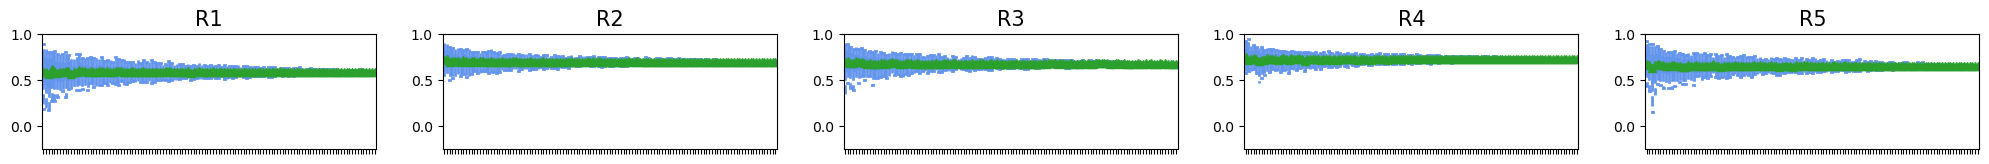

In [91]:
#@title plot the alpha values for every number of workers (in experiment 1)
def data_to_plot(dataframe):
    labels = list(dataframe["No Workers"])

    data = []
    for i in range(len(dataframe)):
        data.append(list(dataframe.iloc[i,1:101]))
    
    return labels, data

def draw_boxplots(ax, data_to_plot, labels, title_text):
    bp = ax.boxplot(data_to_plot, showmeans=True, patch_artist=True, showfliers=False)

      ## change outline color, fill color and linewidth of the boxes
    for box in bp['boxes']:
        # change outline color
        box.set( color='cornflowerblue', linewidth=2)
        # change fill color
        box.set( facecolor = 'white' )

    ## change color and linewidth of the whiskers
    for whisker in bp['whiskers']:
        whisker.set(color='cornflowerblue', linewidth=2,linestyle='--')

    ## change color and linewidth of the caps
    for cap in bp['caps']:
        cap.set(color='cornflowerblue', linewidth=2)

    ## change color and linewidth of the medians
    for median in bp['medians']:
        median.set(color='white', linewidth=0)
      
    ## change color and linewidth of the means
    for mean in bp['means']:
        mean.set(color='red')

    ## change the style of fliers and their fill
    for flier in bp['fliers']:
        flier.set(marker='o', color='blue', alpha=0.5)
      
    ## Custom x-axis labels
    ax.set_xticklabels([])
    ax.set_ylim([-0.25,1])
    ax.get_yaxis().tick_left()
    ax.set_title(title_text, fontsize=15)


link1 = '../data/bootstrap_workers_IRR_CT_rep1.csv'
link2 = '../data/bootstrap_workers_IRR_CT_rep2.csv'
link3 = '../data/bootstrap_workers_IRR_CT_rep3.csv'
link4 = '../data/bootstrap_workers_IRR_CT_rep4.csv'
link5 = '../data/bootstrap_workers_IRR_CT_rep5.csv'

bootstrap1 = pd.read_csv(link1)
bootstrap2 = pd.read_csv(link2)
bootstrap3 = pd.read_csv(link3)
bootstrap4 = pd.read_csv(link4)
bootstrap5 = pd.read_csv(link5)

fig = plt.figure(1, figsize=(25, 1.5))

ax = fig.add_subplot(151)
labels, data = data_to_plot(bootstrap1)
draw_boxplots(ax, data, labels, "R1")

ax = fig.add_subplot(152)
labels, data = data_to_plot(bootstrap2)
draw_boxplots(ax, data, labels, "R2")

ax = fig.add_subplot(153)
labels, data = data_to_plot(bootstrap3)
draw_boxplots(ax, data, labels, "R3")

ax = fig.add_subplot(154)
labels, data = data_to_plot(bootstrap4)
draw_boxplots(ax, data, labels, "R4")

ax = fig.add_subplot(155)
labels, data = data_to_plot(bootstrap5)
draw_boxplots(ax, data, labels, "R5")


fig.savefig("../plots/bootstrap_workers_replications_CT.png",  bbox_inches='tight', format='png', dpi=1200)